# Convert OpenSN data to name,host,type,x,y,z,t,lum

Data downloaded from The Open Supernova Catalog https://sne.space on Aug. 20, 2019

In [1]:
import pandas as pd
import numpy as np
from astropy import units
from astropy.coordinates import SkyCoord
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('OpenSNCat.csv')
#select the ones that have all the data we need
df = df.loc[(df['R.A.'].notnull()) & \
              (df['Dec.'].notnull()) & \
              (df['Disc. Date'].notnull())]# & \
              #(df['dL (Mpc)'].notnull()) & \
              #(df['Mmax'].notnull())]
df

,Name,Disc. Date,Mmax,Host Name,R.A.,Dec.,z,dL (Mpc),Type
0,SN1987A,1987/02/24,-16.3000,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.989...","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11....","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1...",0.0430,II Pec
1,SN2011fe,2011/08/24,-18.2800,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05....","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:2...",0.000804,3.5600,Ia
2,SN2003dh,2003/03/31,-26.8230,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.009,10:44:50...","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:1...",0.1685,836.4300,Ic BL
3,CSS141118:092034+504148,2016/04/22,-19.3000,SDSS J092034.44+504148.7,"09:20:34.300,09:20:34.38,09:20:34.26,09:20:34.32","+50:41:46.60,+50:41:47.7,+50:41:48.4,+50:41:46.68",0.0344,156.2000,II P
4,SN1993J,1993/03/28,-17.4000,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.001,09:55:2...","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01...",-0.000113,2.9000,IIb
5,SN2012fr,2012/10/27,-20.2000,NGC 1365,"03:33:35.99,03:33:35.990,03:33:36.288","-36:07:37.7,-36:07:37.70,-36:07:35.04",0.0054,24.0000,Ia
6,SN2002ap,2002/01/29,-17.8100,NGC 628,"01:36:23.85,01:36:23.851,01:36:23.87","+15:45:13.2,+15:45:13.21,+15:45:13.0",0.002108,9.3443,Ic BL
7,SN2013dy,2013/07/10,-18.3810,NGC 7250,"22:18:17.60,22:18:17.599","+40:34:09.6,+40:34:09.59",0.003889,17.2630,Ia
8,SN2009ip,2012/07/24,-20.0940,NGC 7259,"22:23:08.3,22:23:08.26,22:23:08.261","-28:56:52,-28:56:52.4,-28:56:52.40",0.005944,26.4260,IIn
9,SN2011dh,2011/06/01,-18.1520,NGC 5194,"13:30:05.1055,13:30:05.12,13:30:05.119,13:30:0...","+47:10:10.922,+47:10:11.3,+47:10:10.81,+47:10:...",0.001638,7.2583,IIb


I will have to iterate through the rows, since some coords have multiple entries, and some dates are bad

In [3]:
#get the mean distance, so that I can use that for sources w/o distances
mDist = df['dL (Mpc)'].mean()
mMmax = df['Mmax'].mean()
print("mean distance", mDist)
print("mean Mmax", mMmax)

mean distance 1077.1528440219008
mean Mmax -18.362331456582606


In [4]:
x = []
y = []
z = []
t = []

log10lum = []
name = []
host = []
tpe = []
dflag = []

#for datetime
fmt = '%Y/%m/%d'

N = 1e10
for index, row in df.iterrows():
    bad = False
    
    #there are still some dates that cause errors (e.g., 185/12/07/)
    date = str(row['Disc. Date'])
    pos = date.find(',')
    fmt0 = fmt
    if (pos != -1):    
        date = row['Disc. Date'][0:pos]
    pos1 = date.find('/')
    pos2 = date.rfind('/')
    if (pos1 == -1):
        fmt0 = '%Y'
    if (pos1 != -1 and pos2 == pos1):
        fmt0 = '%Y/%m'
    if (pos1 != -1 and pos2 != pos1 and pos2 == len(date)):
        fmt0 = '%Y/%m/'
    if (fmt0 == fmt):
        val1 = int(date[0:pos1])
        if (val1 <= 12):
            fmt0 = '%m/%d/%Y'
        if (val1 > 12 and val1 < 1800):
            bad = True

    if (not bad):
        dt = datetime.datetime.strptime(date, fmt0) 
        t.append(dt.year + dt.month/12. + dt.day/365.24)
        
        ra = row['R.A.']
        pos = str(ra).find(',')
        if (pos != -1):    
            ra = row['R.A.'][0:pos]

        dec = row['Dec.']
        pos = str(dec).find(',')
        if (pos != -1):    
            dec = row['Dec.'][0:pos]

        if (pd.isna(row['dL (Mpc)'])):
            d = mDist*units.Mpc
            dflag.append(-1)
        else:
            d = row['dL (Mpc)']*units.Mpc
            dflag.append(1)
            
        c1 = SkyCoord(ra, dec, unit=(units.hourangle, units.deg), distance=d).galactic.cartesian
        x.append(c1.x.to(units.Mpc).value)
        y.append(c1.y.to(units.Mpc).value)
        z.append(c1.z.to(units.Mpc).value)

        m = mMmax
        if (pd.notna(row['Mmax'])):
            m = row['Mmax']
        log10lum.append(0.4*(4.74 - m))

        name.append(row['Name'])
        host.append(row['Host Name'])
        tpe.append(row['Type'])
        
    if (index > N):
        break
    

1868.0860712590807 2019.680356295404


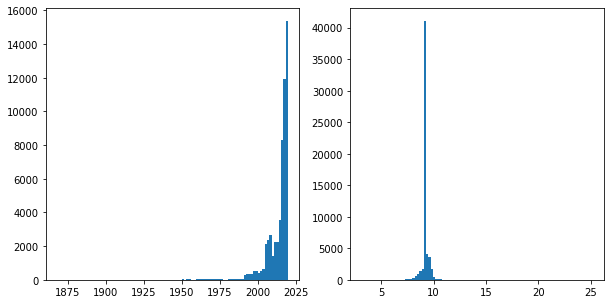

In [5]:
print(min(t), max(t))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
_ = ax1.hist(t,bins=100)
_ = ax2.hist(log10lum,bins=100)

### Convert the types to a float between 0 and 1 for possible colormap

['nan' 'Jovan' 'Ia*' 'SLSN-I?' 'Other' 'Ia-99aa' 'IIn' 'LGRB' 'SLSN-I-R'
 'Ii' 'IIb?' 'II/Ib/c' 'Ia-02ic-like' 'Ib/c' 'II P Pec' 'II P?' 'SLSN-R'
 'IIn/Ibn' 'Ca-rich' 'Impostor-' 'SLSN-II' 'DN' 'Comet' 'II/Ic' 'Ibn'
 'IIn-pec/LBV' 'II?' 'NT' 'Ic/Ic-BL' 'Ia-91bg' 'CV' 'II-Pp.' 'AGN'
 'II-P/L' 'blue' 'Ib-IIb' 'LSQ' 'II L' 'Ibn/IIbn' 'Ib/c-BL' 'Ic?' 'Ia'
 'PISN?' 'SLSN' 'maser' 'Ib/Ic' 'Ic BL' 'Candidate' 'IIb' 'dwarf'
 'Ia-02cx' 'Dwarf' 'LRV?' 'Ic Pec' 'LPV' 'Ib/IIb' 'SLSN-II?' 'IIn-09ip'
 'IIn?' 'SLSN-I' 'LBV' 'Super-Luminous Ic' 'TDE' 'Ia-p' 'Ia-HV' 'CN'
 'BL-Ic' 'I Pec' 'II' 'Galaxy' 'Ia Pec' 'II P' 'Iax[02cx-like]' 'removed'
 'SLSN-IIn' 'Ib/Ic (Ca rich?)?' 'Ib Pec' 'IIn Pec' 'Ic-lum?' 'Variable'
 'BL' 'Ia-91T' 'Ia?' 'LCH' 'II/IIb' 'Ia CSM' 'Candidate?' 'I-faint' 'Ic'
 'nIa' 'Ib-Ca' 'Ia/Ic' 'Ib-Ca-rich' 'IIb/Ib/Ic' 'Ib/c?' 'Star' 'I' 'Pec'
 'LBV to IIn' 'IIb/Ib' 'Lensed SN Ia' 'I?' 'II Pec?' 'IIb/Ib/Ic (Ca rich)'
 'Ia-pec.' 'II-p' 'other' 'Ia Pec?' 'II/LBV' 'XRB' 'II Pec' 'CC' 'SLSN?'

/Users/ageller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


ntotal: 56744
nremoved: 139
nIa: 11395


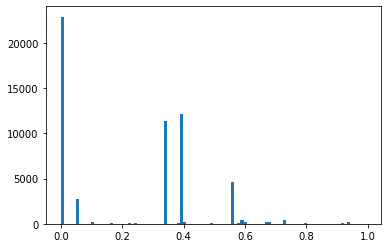

In [6]:
utpe = np.array(list(set(tpe)))
print(utpe)
tp = []
nremoved = 0
nIa = 0
for tt in tpe:
    xx = np.where(utpe == tt)[0]
    if (len(xx) == 0): #nan values
        tp.append(0)
    else:
        tp.append(xx[0]/len(utpe))
        
    if (tt == 'removed'):
        nremoved += 1
    if (tt == 'Ia'):
        nIa += 1

print("ntotal:", len(tp))
print("nremoved:", nremoved)
print("nIa:", nIa)

f, ax = plt.subplots()
_ = ax.hist(tp,bins=100)

### Write this to a "raw" file

In [7]:
import csv
csvfile = open("OpenSNCatConverted.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)

for i in range(len(x)):
    csvwriter.writerow([x[i], y[i], z[i], 
                        t[i], log10lum[i], tp[i],
                        dflag[i], 2, 3])
csvfile.close()


frac = 0.01
csvfile = open("OpenSNCatConvertedSmall.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)

for i in range(len(x)):
    xx = np.random.random()
    if (xx <= frac):
        csvwriter.writerow([x[i], y[i], z[i], 
                            t[i], log10lum[i], tp[i],
                            dflag[i], 2, 3])
csvfile.close()

In [8]:
print(log10lum[19])

9.240932582633041


In [9]:
print(pd.isna(df['Mmax'][18]))
print(df['Mmax'][18])
print(mMmax)
print(0.4*(4.74 - mMmax))

False
-18.5
-18.362331456582606
9.240932582633041
